In [1]:
import torch, copy, sys
from torch import Tensor,zeros
from torch.nn import Module, RNN, GRU, LSTM, Linear, CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
from torch.optim.adam import Adam
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from typing import Tuple
from itertools import product

from LAB3_1.utils import compute_acc, show_loss, Sequential_mnist
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model

In [2]:
class Recurrent_RNN(Module):
    def __init__(self,rnn_type:str, hidden: int, layers:int, bi:bool):

        super(Recurrent_RNN, self).__init__()

        self.criteria = CrossEntropyLoss()

        if rnn_type == "RNN":
            self.rnn = RNN(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = LSTM(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = GRU(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)

        B = 2 if bi else 1
        self.readout = Linear(B * hidden, 10)

    def forward(self, x: Tensor, y:Tensor) -> Tensor:

        out, _ = self.rnn(x)
        y_pred =  self.readout(out[:,-1,:])

        loss = None
        if y is not None:
            loss = self.criteria(y_pred, y)
        return (loss, y_pred) if loss is not None else y_pred

In [3]:
class RNN_trainer:
    def __init__(self, rnn_type:str, hidden:int, layers:int, bi:bool):

        # model
        self.model = Recurrent_RNN(rnn_type, hidden=hidden, layers=layers, bi=bi).to(gpu)

    def fit(self, dataset:Dataset, epochs:int=2, lr:float=0.001)->Tuple[Tensor,Tensor]:

        loader = DataLoader(dataset, batch_size=64)
        opt = Adam(self.model.parameters(), lr)

        loss, y, y_pred = 0, None, None
        history_tr, accuracy_tr = zeros(epochs), zeros(epochs)

        self.model.train()
        for epoch in tqdm(range(epochs)):

            for x, y in loader:
                x,y = x.to(gpu), y.to(gpu)

                opt.zero_grad()
                loss, y_pred = self.model(x, y)
                loss.backward()
                clip_grad_norm_(self.model.parameters(), 1.5)
                opt.step()

            history_tr[epoch] = loss.item()
            accuracy_tr[epoch] = compute_acc(y_pred,y)
            if epoch % 5 == 0:
                print(f'Epoch {epoch} Loss: {loss}', f'Accuracy: {accuracy_tr[epoch]}', sep='\t')

        return history_tr, accuracy_tr

    def validate(self, dataset:Dataset) -> Tuple:

        loader = DataLoader(dataset, batch_size=64)
        cum_loss, cum_acc = 0, 0

        self.model.eval()
        with torch.no_grad():
            for x, y in loader:
                x,y = x.to(gpu), y.to(gpu)
                loss, y_pred = self.model(x, y)
                cum_loss += loss.item()
                cum_acc += compute_acc(y_pred, y)

        cum_loss /= len(loader)
        cum_acc /= len(loader)

        return  cum_loss, cum_acc


In [4]:
ranges_to_explore = {
    "units" : [15],
    "epochs" : [5],
    "lr" : [0.001, 0.004],
    "layers": [1, 2],
    "bi" : [True]
}

class GridSearch:

    def __init__(self, rnn_type:str, tr:Dataset, dev:Dataset):

        self.rnn_type = rnn_type
        all_configs = [dict(zip(ranges_to_explore.keys(), configs)) for configs in product(*ranges_to_explore.values())]

        print("Number of configurations to try: ",len(all_configs))
        # returns the performance in each configuration, the best model and the history of the loss
        rank, best, loss = self.run(tr, dev, [all_configs[0]])

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best
        self.tr_loss = loss

    def run(self, tr:Dataset, dev:Dataset, configs:list):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # the keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss during the epochs
        best, loss = None, None
        best_dev_loss = -sys.maxsize

        for idx, config in enumerate(configs):
            print("Config: ",idx)

            trainer = RNN_trainer(rnn_type=self.rnn_type,
                                  hidden=config["units"],
                                  layers=config["layers"],
                                  bi=config["bi"])

            history, acc_tr  = trainer.fit(tr, config["epochs"], config["lr"])
            _, acc_vl = trainer.validate(dev)
            rank.append((config, round(acc_tr[-1].item(), 6), round(acc_vl, 6)))

            # we keep the best model
            if best_dev_loss < acc_vl:
                best_dev_loss = acc_vl
                loss = copy.deepcopy(history)
                best = copy.deepcopy(trainer)

        return rank, best, loss

### Bonus-Track Assignment 2: Sequential MNIST classification task

In [10]:
tr_dataset, dev_dataset,ts_dataset = Sequential_mnist("train"), Sequential_mnist("dev"), Sequential_mnist("test")

In [5]:
gs = GridSearch("LSTM", tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

Number of configurations to try:  4
Config:  0


 20%|██        | 1/5 [00:05<00:20,  5.21s/it]

Epoch 0 Loss: 2.328359365463257	Accuracy: 0.0


100%|██████████| 5/5 [00:25<00:00,  5.01s/it]



The best solution in  ({'units': 15, 'epochs': 5, 'lr': 0.001, 'layers': 1, 'bi': True}, 0.375, 0.34574)


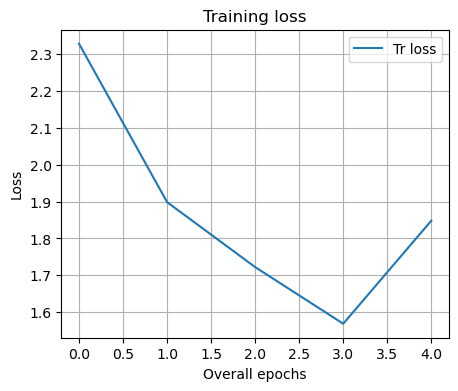

In [7]:
show_loss(gs.tr_loss)

In [15]:
tr_loss, tr_acc = best_model.validate(tr_dataset)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

dev_loss, dev_acc = best_model.validate(dev_dataset)
print(f'Train loss: {round(dev_loss, 6)}', f'Accuracy: {round(dev_acc, 3)}')

test_loss, test_acc = best_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 1.716066 Accuracy: 0.34
Train loss: 1.690229 Accuracy: 0.346
Train loss: 1.727132 Accuracy: 0.327


In [8]:
# def train(model:Module,dataset:Dataset,lr:float,epochs):
#
#     optimizer = Adam(model.parameters(),lr=lr)
#     criterion = CrossEntropyLoss()
#
#     loader = DataLoader(dataset, batch_size=64)
#     for epoch in tqdm(range(epochs)):
#         for x, y in loader:
#             x,y = x.to(gpu), y.to(gpu)
#
#             optimizer.zero_grad()
#             loss, y_pred = model(x, y)
#             loss.backward()
#             clip_grad_norm_(model.parameters(), 1)
#             optimizer.step()
#
#         if epoch % 5 == 0:
#             print(f'Epoch {epoch} Loss: {loss}', f'Accuracy: {compute_acc(y_pred,y)}', sep='\t')

In [9]:
#
# dr_tr = Sequential_mnist(True)
# train(Recurrent_RNN("LSTM", 10, 2, True).to(gpu), dr_tr, 0.001, 128)